# CNN using Regression Age Detection

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_csv_path = "/content/drive/MyDrive/Colab Notebooks/faces/train.csv"
train_images_path = "/content/drive/MyDrive/Colab Notebooks/faces/Train"

In [4]:
train_df = pd.read_csv(train_csv_path)

In [5]:
print("Training Data Info:")
print(train_df.info())
print(train_df['Class'].value_counts())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19906 non-null  object
 1   Class   19906 non-null  object
dtypes: object(2)
memory usage: 311.2+ KB
None
Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


In [6]:
class_counts = train_df['Class'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']
fig = px.bar(class_counts, x='Class', y='Count',
             labels={'Class': 'Class', 'Count': 'Count'},
             title="Class Distribution",
             color='Count', color_continuous_scale='Blues')
fig.show()

In [7]:
class_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
train_df['Class'] = train_df['Class'].map(class_mapping)

## Loading Dataset

In [8]:

def load_and_preprocess_image(image_path, target_size=(150, 150)):

    if not os.path.exists(image_path):
        return None
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.resize(image, target_size)
    return image

In [10]:
train_images = []
train_labels = []
for idx, row in train_df.iterrows():
    image_path = os.path.join(train_images_path, row['ID'])
    image = load_and_preprocess_image(image_path)
    if image is not None:
        train_images.append(image)
        train_labels.append(row['Class'])



train_labels = np.array(train_labels)
train_labels = to_categorical(train_labels, num_classes=3)

In [11]:
train_images = np.array(train_images)

In [12]:
print(f"total train images:{len(train_images)} ")

total train images:1675 


In [13]:
train_labels[0]

array([1., 0., 0.], dtype=float32)

# Five Images from Each Classes

In [14]:
young_images = []
middle_images = []
old_images = []
for image,label in zip(train_images,train_labels):
  if (len(young_images) == 5 and len(middle_images) == 5 and len(old_images) == 5):
    break
  if label[0] == 1 and len(young_images) < 5:
      young_images.append(image)
  elif label[1] == 1 and len(middle_images) < 5:
      middle_images.append(image)
  elif label[2] == 1 and len(old_images) < 5:
        old_images.append(image)


In [15]:
len(young_images),len(middle_images),len(old_images)

(5, 5, 5)

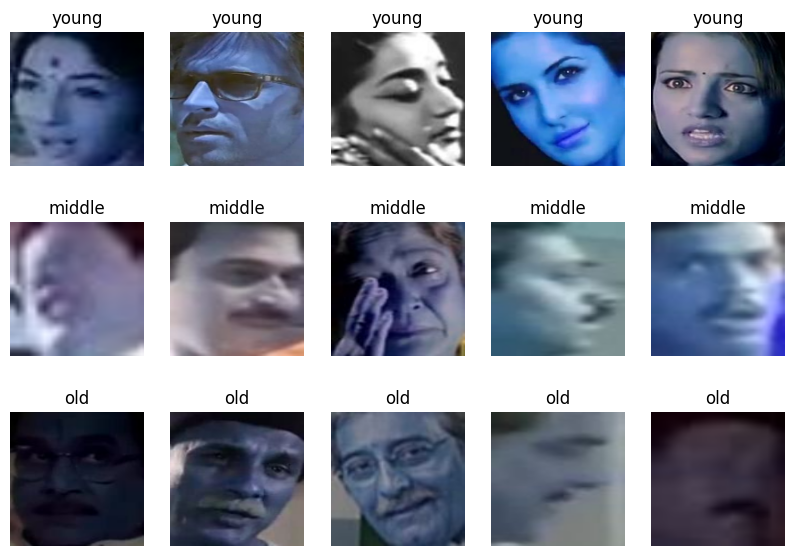

In [16]:
fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 5
i = j  = 0
s=1
while i < rows:
  while j < columns:

    fig.add_subplot(rows,columns,s)
    plt.axis('off')
    if i == 0:
      plt.title('young')
      plt.imshow(young_images[j])
    elif i==1:
      plt.title('middle')
      plt.imshow(middle_images[j])
    else:
      plt.title('old')
      plt.imshow(old_images[j])
    s = s + 1
    j = j + 1
  j=0
  i = i + 1


In [17]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2
)

train_generator = datagen.flow(train_images, train_labels)
validation_generator = datagen.flow(train_images, train_labels)

# Model Training



> AlexNet



In [18]:
model = Sequential()
model.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= (150,150,3),
                        kernel_initializer= 'he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

model.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

model.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

model.add(Flatten())
model.add(Dense(4096, activation= 'relu'))
model.add(Dense(4096, activation= 'relu'))
model.add(Dense(1000, activation= 'relu'))
model.add(Dense(3, activation= 'softmax'))

model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [19]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/faces.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [20]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=80,callbacks=[checkpoint])

Epoch 1/80
53/53 [==============================] - 27s 371ms/step - loss: 2.2609 - accuracy: 0.5355 - val_loss: 0.9448 - val_accuracy: 0.5510
Epoch 2/80
53/53 [==============================] - 20s 374ms/step - loss: 0.9455 - accuracy: 0.5510 - val_loss: 0.9514 - val_accuracy: 0.5510
Epoch 3/80
53/53 [==============================] - 17s 317ms/step - loss: 0.9448 - accuracy: 0.5516 - val_loss: 0.9339 - val_accuracy: 0.5510
Epoch 4/80
53/53 [==============================] - 21s 409ms/step - loss: 0.9396 - accuracy: 0.5504 - val_loss: 0.9276 - val_accuracy: 0.5552
Epoch 5/80
53/53 [==============================] - 24s 458ms/step - loss: 0.9398 - accuracy: 0.5600 - val_loss: 0.9302 - val_accuracy: 0.5588
Epoch 6/80
53/53 [==============================] - 20s 391ms/step - loss: 0.9237 - accuracy: 0.5654 - val_loss: 0.9086 - val_accuracy: 0.5618
Epoch 7/80
53/53 [==============================] - 19s 365ms/step - loss: 0.9071 - accuracy: 0.5684 - val_loss: 0.8876 - val_accuracy: 0.5755

In [21]:
model.save('/content/drive/MyDrive/faces_final.keras')

In [22]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

53/53 [==============================] - 9s 169ms/step - loss: 0.2430 - accuracy: 0.9218
Validation Loss: 0.243040531873703, Validation Accuracy: 0.9217910170555115


In [23]:
def extract_labels_and_preds(generator):
    labels = []
    preds = []
    for batch in generator:
        batch_images, batch_labels = batch
        batch_preds = model.predict(batch_images)
        labels.extend(np.argmax(batch_labels, axis=1))
        preds.extend(np.argmax(batch_preds, axis=1))
        if len(labels) >= len(generator) * generator.batch_size:
            break
    return np.array(labels), np.array(preds)

val_labels, val_preds_classes = extract_labels_and_preds(validation_generator)

1/1 [==============================] - 0s 32ms/step


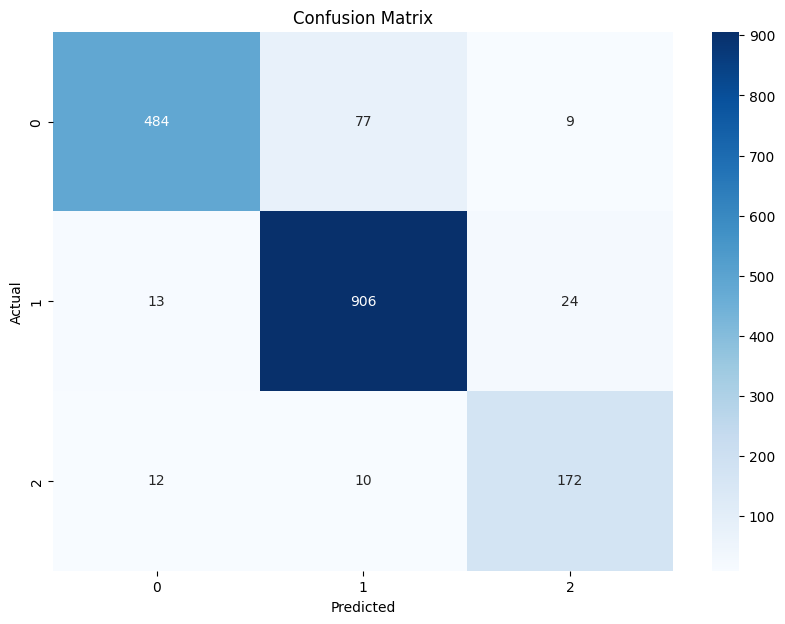

In [24]:
cm = confusion_matrix(val_labels, val_preds_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
from sklearn.metrics import classification_report

In [26]:
print("Classification Report:")
print(classification_report(val_labels, val_preds_classes, target_names=['YOUNG', 'MIDDLE', 'OLD']))

Classification Report:
              precision    recall  f1-score   support

       YOUNG       0.95      0.85      0.90       570
      MIDDLE       0.91      0.96      0.94       943
         OLD       0.84      0.89      0.86       194

    accuracy                           0.92      1707
   macro avg       0.90      0.90      0.90      1707
weighted avg       0.92      0.92      0.91      1707



In [27]:
fig = px.line(history.history, y=['accuracy', 'val_accuracy'],
              labels={'index': 'Epoch', 'value': 'Accuracy'},
              title='Training and Validation Accuracy',
              markers=True)
fig.update_traces(mode='markers+lines')
fig.show()

fig = px.line(history.history, y=['loss', 'val_loss'],
              labels={'index': 'Epoch', 'value': 'Loss'},
              title='Training and Validation Loss',
              markers=True)
fig.update_traces(mode='markers+lines')
fig.show()